# ConvNP

[The `ConvNP` class](../reference/model/convnp.rst) implements a convolutional neural process, and is a subclass of `DeepSensorModel`.
This page will walk through the ConvNP architecture, explain important features, and provide some tips for using the model.
For further background reading, check out the [](../resources.md) page.

:::{seealso}
The `ConvNP` class wraps around the fanstastic [`neuralprocesses` library](https://github.com/wesselb/neuralprocesses) by Wessel Bruinsma. Go and give it a star to show your appreciation! ⭐
:::

## ConvNP architecture

Here is a high-level schematic of the ConvNP architecture used in DeepSensor:

<img src="../../figs/convnp_arch.png" alt="ConvNP architecture" width="700"/>

The ConvCNP learns: $p_\theta ( \mathbf{y}^{(t)} ; \mathbf{x}^{(t)}, \phi(C))$, 
where $p_\theta$ specifies a predictive distribution over target values $\mathbf{y}^{(t)}$ given target locations $\mathbf{x}^{(t)}$ and the context data $C$.
All the distribution parameters $\phi$ (such as the mean and variance of a Gaussian likelihood) *depend on the entire context set $C$, including the $y$-values*!
One effect of this is that the ConvNP's uncertainty can hypothetically become *more uncertain* if neighbouring observations disagree.
This makes the ConvNP far more flexible than standard probabilistic models, like GPs.

Other benefits of the ConvNP are that it can handle:
* Fusing multiple context sets
* Off-the-grid and gridded modalities
* Multi-resolution data
* Missing data
* Predicting at arbitrary target locations
* Predicting multiple (disjoint) target sets
* Uncertainty quantification
* $O(N)$ inference cost (for most variants)

```{caution} 
It's important to note that the flexibility of the ConvNP makes it a *data hungry model*.
It has to *learn how to condition on data* from scratch, which requires
seeing many examples of different context sets and target sets during training.
The `TaskLoader` provides the necessary functionality for this.
However, if your data is spatially or temporally sparse (and there isn't 
a more abundant dataset to transfer learn from), then the ConvNP may not be
the best model for your use case.
```

```{note}
The 'ConvNP' is actually a *class* of model architectures, rather than a single model.
There are different variants of the ConvNP, such as the conditional NP (ConvCNP), the Gaussian NP (ConvGNP), and the
latent NP (ConvLNP). Each of these can be instantiated from the `ConvNP` class by initialising the model with
different hyperparameters.
```

## Initialising a ConvNP

The key arguments for initialising a `ConvNP` are:
* A `DataProcessor`: Used to inherit the high-level `.predict` method from the `DeepSensorModel` base class (detailed in the [](./prediction.ipynb) page).
* A `TaskLoader`: Under the hood, DeepSensor will use the `TaskLoader`'s context/target data and configuration to infer sensible defaults for hyperparameters that are not set by the user. 

In [ ]:
import logging
logging.captureWarnings(True)

from deepsensor.data import DataProcessor, TaskLoader
from deepsensor.data import construct_circ_time_ds
from deepsensor.data.sources import get_ghcnd_station_data, get_era5_reanalysis_data, get_earthenv_auxiliary_data, get_gldas_land_mask

import pandas as pd
import numpy as np

# Using the same settings allows use to use pre-downloaded cached data
data_range = ("2015-06-25", "2015-06-30")
extent = "europe"
station_var_IDs = ["TAVG", "PRCP"]
era5_var_IDs = ["2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind"]
auxiliary_var_IDs = ["elevation", "tpi"]
cache_dir = "../../.datacache"

station_raw_df = get_ghcnd_station_data(station_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir)
era5_raw_ds = get_era5_reanalysis_data(era5_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir)
auxiliary_raw_ds = get_earthenv_auxiliary_data(auxiliary_var_IDs, extent, "1KM", cache=True, cache_dir=cache_dir)
land_mask_raw_ds = get_gldas_land_mask(extent, cache=True, cache_dir=cache_dir)

data_processor = DataProcessor("../deepsensor_config/")
era5_ds = data_processor(era5_raw_ds)
aux_ds, land_mask_ds = data_processor([auxiliary_raw_ds, land_mask_raw_ds], method="min_max")
station_df = data_processor(station_raw_df)

# Add 2D circular day of year variable to land mask context set
dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
land_mask_ds["cos_D"] = doy_ds["cos_D"]
land_mask_ds["sin_D"] = doy_ds["sin_D"]

In [3]:
import deepsensor.torch
from deepsensor.model import ConvNP

In [2]:
task_loader = TaskLoader(
    context=[station_df["TAVG"], era5_ds, land_mask_ds],
    target=station_df["TAVG"],
    aux_at_targets=aux_ds,
    links=[(0, 0)],
)
print(task_loader)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('TAVG',), ('2m_temperature', '10m_u_component_of_wind', '10m_v_component_of_wind'), ('GLDAS_mask',))
Target variable IDs: (('TAVG',),)
Auxiliary-at-target variable IDs: ('elevation', 'tpi')


In [4]:
model = ConvNP(data_processor, task_loader, internal_density=500)

dim_yc inferred from TaskLoader: (1, 3, 1)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 2
Setting aux_t_mlp_layers: (64, 64, 64)
encoder_scales inferred from TaskLoader: [0.001, 0.0022727272007614374, 0.0022727272007614374]
decoder_scale inferred from TaskLoader: 0.002


In [5]:
print(model)

ConvNP with config:
{
    "dim_x": 2,
    "dim_yc": [
        1,
        3,
        1
    ],
    "dim_yt": 1,
    "dim_aux_t": 2,
    "dim_lv": 0,
    "conv_arch": "unet",
    "unet_channels": [
        64,
        64,
        64,
        64
    ],
    "unet_resize_convs": true,
    "unet_resize_conv_interp_method": "bilinear",
    "aux_t_mlp_layers": [
        64,
        64,
        64
    ],
    "likelihood": "het",
    "unet_kernels": 5,
    "internal_density": 500,
    "encoder_scales": [
        0.001,
        0.0022727272007614374,
        0.0022727272007614374
    ],
    "encoder_scales_learnable": false,
    "decoder_scale": 0.002,
    "decoder_scale_learnable": false,
    "num_basis_functions": 64,
    "epsilon": 0.01
}


## The ConvNP's internal grid

The ConvNP uses a discretised internal grid to process the context data.
The density of internal grid points is defined by the `internal_density` parameter.
An `internal_density` of 500 means a 1x1 patch of input space will contain 500x500 internal grid points.

Generally, the `internal_density` should be as high as the highest-resolution context or target variable.
Beyond this point, increasing the `internal_density` will not improve the model's performance.
Thankfully, DeepSensor will determine the highest-resolution variable and set the `internal_density` under-the-hood
if you don't specify `internal_density` in the `ConvNP` constructor.
However, the computationl cost of the model scales quadratically with `internal_density`, so
you may wish to lower the `internal_density` to speed up training and inference.

## SetConv context encoding

The SetConv encoder maps the various context sets onto the ``ConvNP``'s internal grid.
This works by placing a Gaussian kernel at each $(\mathbf{x}, \mathbf{y})$ context observation, weighted by the $N$-D observation values $\mathbf{y}$, and then evaluating the sum of the kernels on the internal grid. These $N$ channels are called the 'data channels'.
Each encoded context set also has a 'density channel', formed using the same Gaussian kernel procedure but without weighting the kernels by the observation values, capturing the density of context observations and revealing areas of missing data.

The output of the SetConv encoder for a particular collection of context sets is the concatenation of all the density and data channels for each context set in a `Task`.

In [23]:
task = task_loader("2015-06-25", "all", "all")
encoding = deepsensor.model.nps.compute_encoding_tensor(model, task)
print(f"SetConv encoding tensor shape: {encoding.shape}")

SetConv encoding tensor shape: (1, 8, 432, 608)


The gridded context encoding of a particular `Task` can be visualised using the `deepsensor.plot.context_encoding` function.

This can also be an extremely useful debugging tool. For example:
- Help with understanding the `context_sampling` schemes provided by the `TaskLoader`. Try using different `context_sampling` schemes and visualise the SetConv encoding to see how the context sets are sampled (as well as printing the `Task` to see the data shapes).
- Do the length scales of the encoded data seem reasonable (i.e. avoids blurring high frequency components while not being so small to induce checkerboard artefacts)?
- Are the channel magnitudes in the encoding reasonable?
- Are there any nan values?

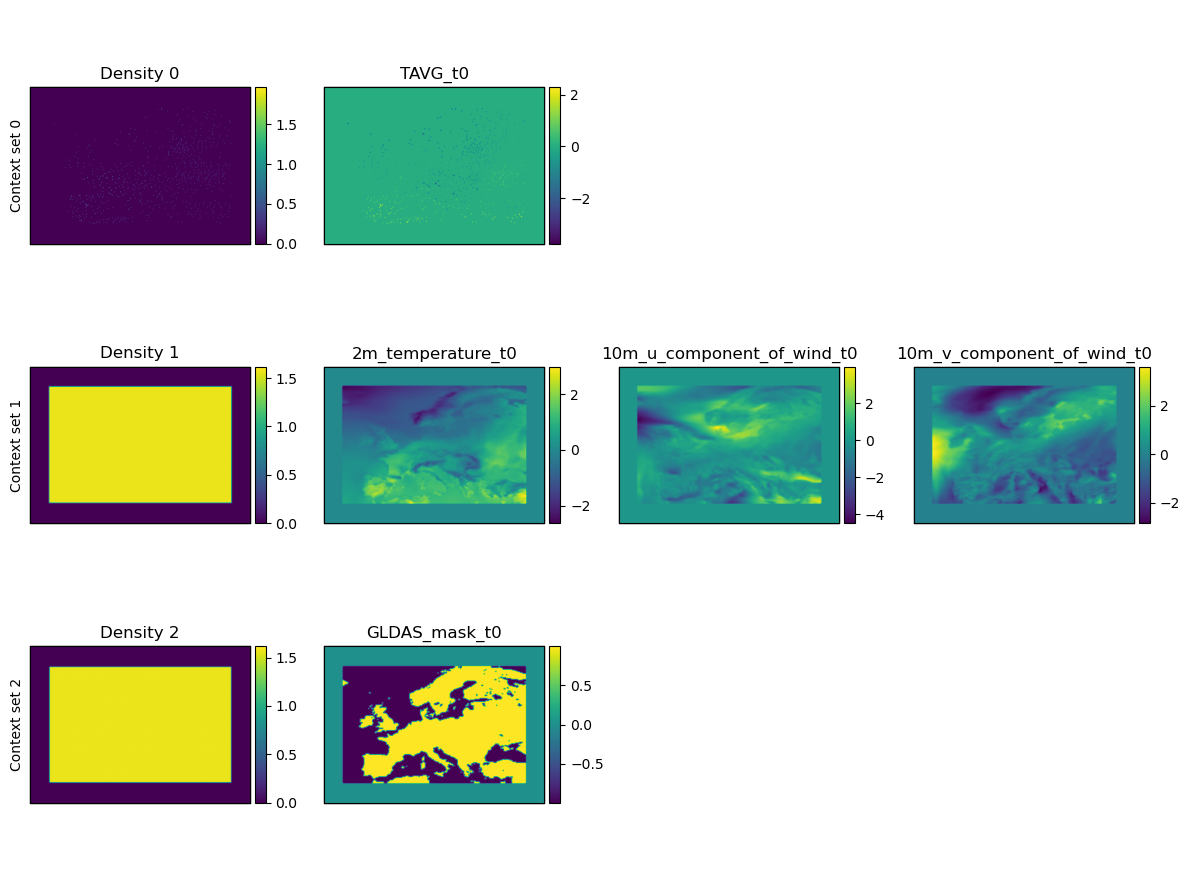

In [20]:
fig = deepsensor.plot.context_encoding(model, task, task_loader)

It's tricky to see the encoded station context points, so let's zoom in on that context set specifically to get a feel for how the ``ConvNP`` receives station data:

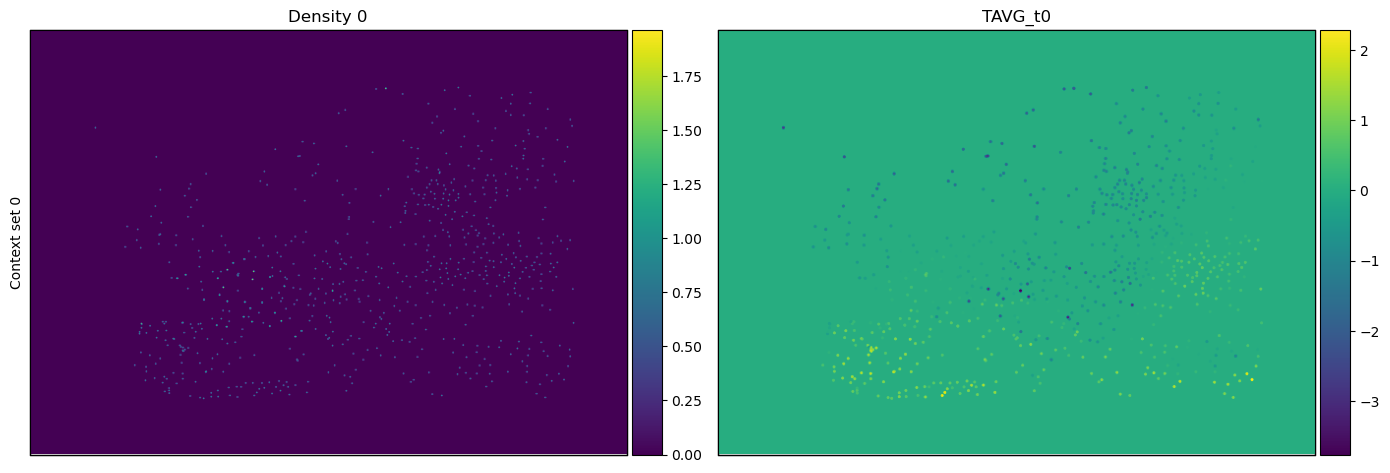

In [18]:
fig = deepsensor.plot.context_encoding(model, task, task_loader, context_set_idxs=0, size=7)

## Breaking ConvNP stationarity using auxiliary variables

The convolutional architecture of U-Net module of the `ConvNP` is translation equivariant.
This means shifting the context data results in a corresponding shift in the output prediction.
If we only had one context set, the `ConvNP` would be *stationary*.
However, environmental data is often highly spatially *non-stationary*.
The behaviour of geophysical variables can vary significantly in different regions of the globe.
Modelling this spatial non-stationarity is important for making accurate predictions from the
available data.

A trick for breaking stationarity/translation equivariance in the `ConvNP` is to add auxiliary variables to its
context sets.
Now, if an observation is shifted, the static auxiliary variable/s will be different, and the `ConvNP` prediction
will also be different.

It is generally advisable to use auxiliary variables that are physically grounded (rather than
hand-crafted features like latitude/longitude).
Elevation can be a good auxiliary variable to use, as it is often correlated with surface geophysical variables,
and it allows the model to transfer knowledge about topographic effects from one region to another.

To add *temporal non-stationarity*, we can also add a circular time variable to one of the context sets.
This is shown above with the `cos_D` and `sin_D` variables (the cosine and sine of the day of year).
DeepSensor provides a `construct_circ_time_ds` function for this purpose (shown in one of the collapsed
code cells above).


## Receptive field

The use of a convolutional architecture (U-Net) in the `ConvNP` model means that the model has a receptive field. This is the area of the input data that influences the prediction at a given point. The receptive field is a function of the U-Net architecture, such as number of layers, filter size, and internal discretisation density.

The receptive field can be visualised using the `deepsensor.plot.receptive_field` function. This will unnormalise the receptive field and plot it on a map of the globe, which can be useful for understanding the spatial extent of the receptive field.

Some things to consider are:
- Is the receptive field too large (i.e. much larger than the range of context and target data)? This can cause excessive zero-padding.
- Is the receptive field too small (i.e. smaller than the correlation length scale between context and target data)? The ``ConvNP`` cannot learn correlations greater than the receptive field.

You can increase/decrease the receptive field by:
- Increasing/decreasing the number of layers in the U-Net
- Increasing/decreasing the filter size in the U-Net
- Decreasing/increasing the internal discretisation density of the U-Net

Note that the first two options will also affect the number of parameters in the model, decreasing or increasing model capacity. To counteract this, the number of channels in the U-Net (which has no effect on receptive field) can be adjusted.

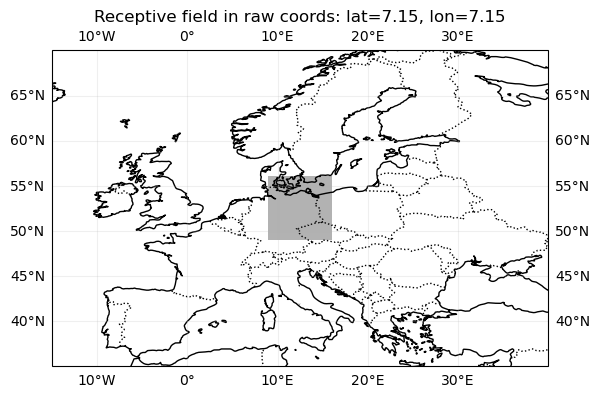

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cf
fig = deepsensor.plot.receptive_field(model.model.receptive_field, data_processor, ccrs.PlateCarree(), "europe")
fig.axes[0].add_feature(cf.BORDERS, linestyle=':')

## The likelihood parameter

The `likelihood` parameter specifies the output distribution of the `ConvNP`.

The current options are:
* `cnp` (the default): Conditional neural process (CNP) with a Gaussian likelihood. Here, 'conditional' means that the target variables are modelled as conditionally independent given the context set (i.e. the model does not learn correlations between the target variables).
* `cnp-spikes-beta`: CNP with two delta functions (spikes) at 0 and 1, and a Beta distribution between 0 and 1. Useful for modelling data that lies in [0, 1] (e.g. fractional cloud cover).
* `gnp`: Gaussian neural process (GNP) with a joint Gaussian likelihood. This is a generalisation of the CNP that allows for correlations between the target variables.

## Saving and loading a ConvNP

Similarly to the ``DataProcessor`` and ``TaskLoader`` objects, a ``ConvNP`` object can be saved using the ``save`` method, and then loaded using the ``ConvNP`` constructor.

In [8]:
model.save("../deepsensor_config/")

In [13]:
model_loaded = ConvNP(data_processor, task_loader, "../deepsensor_config/")

In [14]:
mean_bef = model.mean(task)
mean_loaded = model_loaded.mean(task)
print(np.allclose(mean_bef, mean_loaded))

True
